# IN25 - Validation of the radiosity simulation
This notebook generates plots for the internoise 2025 paper.
At each step, a different simulation validation step will be addressed.

In [30]:
import sparrowpy as sp
import pyfar as pf
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

font={
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 11,
}

plt.rcParams.update(font)

base_dir = os.path.join(os.getcwd(), "resources")

## Form factor validation

### Patch energy conservation

In [4]:
radi = sp.DirectionalRadiosityFast.from_file(
                os.path.join(base_dir, "cube_simple.blend"),
                manual_patch_size=1.,
                )
radi.bake_geometry()

ff_sum = np.sum(radi._form_factors_tilde, axis=0)[:,0,0]

for i,ffs in enumerate(ff_sum):
    print(f'\npatch {i}')
    print(f'    energy:     {ffs:.3f}')
    print(f'    rel error:  {100*(1-ffs)/1:.3f}%')

print(f'global rel error:  {100*(radi._n_patches-np.sum(ff_sum))/radi.n_patches:.3f}%')


D:\Joao_Fatela\dev\sparrowpy\sparrowpy\form_factor\universal.py:48: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'C', False, aligned=True))
  form_factors[i,j] = universal_form_factor(



patch 0
    energy:     0.997
    rel error:  0.267%

patch 1
    energy:     0.997
    rel error:  0.267%

patch 2
    energy:     0.997
    rel error:  0.267%

patch 3
    energy:     0.997
    rel error:  0.267%

patch 4
    energy:     0.997
    rel error:  0.267%

patch 5
    energy:     0.997
    rel error:  0.267%

patch 6
    energy:     0.997
    rel error:  0.267%

patch 7
    energy:     0.997
    rel error:  0.267%

patch 8
    energy:     0.997
    rel error:  0.267%

patch 9
    energy:     0.997
    rel error:  0.267%

patch 10
    energy:     0.997
    rel error:  0.267%

patch 11
    energy:     0.997
    rel error:  0.267%

patch 12
    energy:     0.997
    rel error:  0.267%

patch 13
    energy:     0.997
    rel error:  0.267%

patch 14
    energy:     0.997
    rel error:  0.267%

patch 15
    energy:     0.997
    rel error:  0.267%

patch 16
    energy:     0.997
    rel error:  0.267%

patch 17
    energy:     0.997
    rel error:  0.267%

patch 18
    energy

### Parallel facing patches

In [5]:
from sparrowpy.testing import exact_ff_solutions as solutions

def form_factor_parallel(width, height, distance):
    exact = solutions.parallel_patches(width, height, distance)

    patch_1 = sp.geometry.Polygon(
        points=[[0, 0, 0], [width, 0, 0], [width, 0, height], [0, 0, height]],
        normal=[0, 1, 0],
        up_vector=[1, 0, 0],
    )

    patch_2 = sp.geometry.Polygon(
        points=[
            [0, distance, 0],
            [0, distance, height],
            [width, distance, height],
            [width, distance, 0],
        ],
        normal=[0, -1, 0],
        up_vector=[1, 0, 0],
    )

    univ = sp.form_factor.universal.universal_form_factor(
                    source_pts=patch_1.pts,
                    source_normal=patch_1.normal,
                    source_area=patch_1.area,
                    receiver_pts=patch_2.pts,
                    receiver_normal=patch_2.normal)

    return exact,univ

d=1.
heights = np.arange(d/4,d*4,.001)
err_abs = np.zeros_like(heights)
err_rel = np.zeros_like(heights)

for i,h in enumerate(heights):
    tru, est = form_factor_parallel(h,h,d)
    err_abs[i] = est-tru
    err_rel[i] = 100*err_abs[i]/tru


C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_5352\3919609580.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure[0].show()


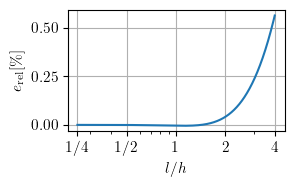

In [6]:
figure = plt.subplots(figsize=(3,2))
plt.semilogx(heights,err_rel)
plt.xlabel('$$l/h$$')
plt.ylabel('$$e_\mathrm{rel} [\%]$$')
plt.grid()
plt.xticks([.25,.5,1,2,4],['$1/4$','$1/2$','$1$','$2$','$4$'])
plt.tight_layout()
figure[0].show()
figure[0].savefig('D:\\Joao_Fatela\\phd\\Papers\\Internoise_2025\\figures\\ff_par.pdf')

### Perpendicular floating patches

In [7]:
def form_factor_perp_commonside(width, height, length):

    exact = solutions.perpendicular_patch_coincidentline(width, height, length)

    patch_1 = sp.geometry.Polygon(
        points=[
            [0, 0, 0],
            [0, length, 0],
            [0, length, height],
            [0, 0, height],
        ],
        normal=[1, 0, 0],
        up_vector=[1, 0, 0],
    )

    patch_2 = sp.geometry.Polygon(
        points=[[0, 0, 0],
                [width, 0, 0],
                [width, length, 0],
                [0, length, 0]],
        normal=[0, 0, 1],
        up_vector=[1, 0, 0],
    )

    univ = sp.form_factor.universal.universal_form_factor(
                    source_pts=patch_1.pts,
                    source_normal=patch_1.normal,
                    source_area=patch_1.area,
                    receiver_pts=patch_2.pts,
                    receiver_normal=patch_2.normal)

    return exact,univ


heights = np.arange(1/4,4,.001)
err_abs = np.zeros_like(heights)
err_rel = np.zeros_like(heights)

for i,h in enumerate(heights):
    tru, est = form_factor_perp_commonside(h,1,h)
    err_abs[i] = est-tru
    err_rel[i] = 100*err_abs[i]/tru

C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_5352\2490095343.py:8: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure[0].show()


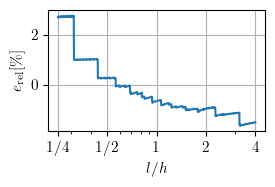

In [8]:
figure = plt.subplots(figsize=(3,2))
plt.semilogx(heights,err_rel)
plt.xlabel('$$l/h$$')
plt.ylabel('$$e_\mathrm{rel} [\%]$$')
plt.grid()
plt.xticks([.25,.5,1,2,4],['$1/4$','$1/2$','$1$','$2$','$4$'])
plt.tight_layout()
figure[0].show()
figure[0].savefig('D:\\Joao_Fatela\\phd\\Papers\\Internoise_2025\\figures\\ff_perp.pdf')

## Infinite diffuse plane

In [9]:
def run_energy_diff_specular_ratio(
        width, length, patch_size, source, receiver):
    """
    Calculate the ratio of diffuse to specular energy for an plane.
    The plane is located in the x-y plane. Its center is at (0, 0, 0).

    Parameters
    ----------
    width : float
        Width of the plane.
    length : float
        length of the plane.
    patch_size : float
        Size of the patches.
    source : pf.Coordinates
        Position of the source.
    receiver : pf.Coordinates
        Position of the receiver in cartesian.

    Returns
    -------
    ratio : float
        Ratio of diffuse to specular energy.
    """
    source_is = source.copy()
    source_is.z *= -1
    reflection_len =  (receiver - source_is).radius[0]
    speed_of_sound = 343
    sampling_rate = 1
    etc_duration = reflection_len/speed_of_sound
    etc_duration=1

    plane = sp.geometry.Polygon(
            [[-width/2, -length/2, 0],
             [width/2, -length/2, 0],
             [width/2, length/2, 0],
             [-width/2, length/2, 0]],
            [1, 0, 0], [0, 0, 1])

    #simulation parameters
    radi = sp.DirectionalRadiosityFast.from_polygon(
        [plane], patch_size)

    brdf_sources = pf.Coordinates(0, 0, 1, weights=1)
    brdf_receivers = pf.Coordinates(0, 0, 1, weights=1)
    brdf = sp.brdf.create_from_scattering(
        brdf_sources,
        brdf_receivers,
        pf.FrequencyData(1, [100]),
        pf.FrequencyData(0, [100]),
    )

    radi.set_wall_brdf(
        np.arange(1), brdf, brdf_sources, brdf_receivers)

    # set air absorption
    radi.set_air_attenuation(
        pf.FrequencyData(
            np.zeros_like(brdf.frequencies),
            brdf.frequencies))

    # initialize source energy at each patch
    radi.init_source_energy(source)

    # gather energy at receiver
    radi.calculate_energy_exchange(
        speed_of_sound=speed_of_sound,
        etc_time_resolution=1/sampling_rate,
        etc_duration=etc_duration,
        max_reflection_order=0)

    I_diffuse = radi.collect_energy_receiver_mono(receiver)

    I_specular = 1/(4*np.pi*reflection_len**2)
    return np.sum(I_diffuse.time)/I_specular

In [15]:
patch_size=.75
width = 75
depth = 75

In [16]:
# colocated s-r
source = pf.Coordinates(0, 0, 2, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
ratio1 = run_energy_diff_specular_ratio(
    width, depth, patch_size, source, receiver)
err1=100*(2-ratio1)/2
print(ratio1)

print(f'Colocated s-r relative error: {err1:.2f}%')


1.9656775890563596
Colocated s-r relative error: 1.72%


In [17]:
# same normal
source = pf.Coordinates(0, 0, 1, weights=1)
receiver = pf.Coordinates(0, 0, 2, weights=1)
ratio2 = run_energy_diff_specular_ratio(
    width, depth, patch_size, source, receiver)
err2=100*(2-ratio2)/2
print(ratio2)

print(f'On-normal s-r relative error: {err2:.2f}%')

1.939486535093248
On-normal s-r relative error: 3.03%


In [18]:
theta = np.deg2rad(np.arange(5,90,5))
ratio3 = np.zeros_like(theta)

for i,th in enumerate(theta):
    source = pf.Coordinates.from_spherical_colatitude(
        0, th, 2/np.cos(th), weights=1)
    receiver = pf.Coordinates.from_spherical_colatitude(
        np.pi, th, 2/np.cos(th), weights=1)
    ratio3[i] = run_energy_diff_specular_ratio(
        width, depth, patch_size, source, receiver)

err3 = 100 * (2*np.cos(theta)-ratio3) / (2*np.cos(theta))

In [40]:
print('Same-height s-r relative error')
for i,e in enumerate(err3):
    print('\\hline')
    print(f'{np.rad2deg(theta[i]):.0f}º & {2*np.cos(theta[i]):.3f} & {ratio3[i]:.3f} & {(2*np.cos(theta[i])-ratio3[i]):.3f} & {e:.2f}% \\\\')


Same-height s-r relative error
\hline
5º & 1.992 & 1.959 & 0.033 & 1.67% \\
\hline
10º & 1.970 & 1.939 & 0.030 & 1.55% \\
\hline
15º & 1.932 & 1.906 & 0.026 & 1.34% \\
\hline
20º & 1.879 & 1.859 & 0.020 & 1.09% \\
\hline
25º & 1.813 & 1.798 & 0.015 & 0.80% \\
\hline
30º & 1.732 & 1.723 & 0.009 & 0.50% \\
\hline
35º & 1.638 & 1.635 & 0.004 & 0.22% \\
\hline
40º & 1.532 & 1.532 & -0.000 & -0.02% \\
\hline
45º & 1.414 & 1.417 & -0.003 & -0.21% \\
\hline
50º & 1.286 & 1.290 & -0.004 & -0.33% \\
\hline
55º & 1.147 & 1.152 & -0.004 & -0.39% \\
\hline
60º & 1.000 & 1.004 & -0.004 & -0.38% \\
\hline
65º & 0.845 & 0.848 & -0.003 & -0.32% \\
\hline
70º & 0.684 & 0.686 & -0.002 & -0.23% \\
\hline
75º & 0.518 & 0.518 & -0.001 & -0.12% \\
\hline
80º & 0.347 & 0.347 & 0.000 & 0.03% \\
\hline
85º & 0.174 & 0.173 & 0.002 & 1.02% \\


C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_5352\2924517430.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure[0].show()
C:\Users\WS2080-01\AppData\Local\Temp\ipykernel_5352\2924517430.py:18: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  figure[0].show()


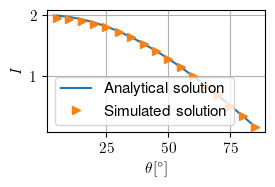

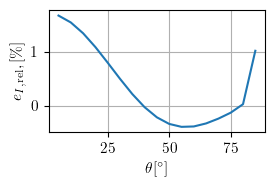

In [39]:
figure = plt.subplots(figsize=(3,2))
plt.plot(theta/np.pi*180,2*np.cos(theta))
plt.plot(theta/np.pi*180,ratio3,'>')
plt.xlabel('$$\\theta [^{\circ}]$$')
plt.ylabel('$$I$$')
plt.grid()
plt.tight_layout()
plt.legend(['Analytical solution','Simulated solution'])
figure[0].show()
figure[0].savefig('D:\\Joao_Fatela\\phd\\Papers\\Internoise_2025\\figures\\infplane_raw.pdf')

figure = plt.subplots(figsize=(3,2))
plt.plot(theta/np.pi*180,err3)
plt.xlabel('$$\\theta [^{\circ}]$$')
plt.ylabel('$$e_{I,\mathrm{rel}},[\%]$$')
plt.grid()
plt.tight_layout()
figure[0].show()
figure[0].savefig('D:\\Joao_Fatela\\phd\\Papers\\Internoise_2025\\figures\\infplane_err.pdf')